Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. 

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook,nlp]
```

In [1]:
!pip install flaml[nlp,ray,notebook,optuna];
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# !pip install flaml[catboost]

## 2. Sentiment Classification Example
## Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas().iloc[0:10000]
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas().iloc[0:10000]
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [2]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
ray.init()

E0301 12:27:52.005567198   72646 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0301 12:27:52.093042924   72646 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
2022-03-01 12:27:52,631	ERROR services.py:1383 -- Failed to start the dashboard: Failed to read dashbord log: [Errno 2] No such file or directory: '/tmp/ray/session_2022-03-01_12-27-50_836238_72646/logs/dashboard.log'
E0301 12:27:52.639055605   72646 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0301 12:27:52.669543325   72646 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{'node_ip_address': '155.246.89.124',
 'raylet_ip_address': '155.246.89.124',
 'redis_address': '155.246.89.124:6379',
 'object_store_address': '/tmp/ray/session_2022-03-01_12-27-50_836238_72646/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-01_12-27-50_836238_72646/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-01_12-27-50_836238_72646',
 'metrics_export_port': 46695,
 'gcs_address': '155.246.89.124:39835',
 'node_id': '34d5a8dcf66552f4e5753e10fad2035faf7f07b5649369bf713418cc'}

(raylet) Traceback (most recent call last):
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/agent.py", line 21, in <module>
(raylet)     import ray.dashboard.utils as dashboard_utils
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/utils.py", line 29, in <module>
(raylet)     from ray.dashboard.optional_deps import (aiohttp, aiosignal, aioredis, hdrs,
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/optional_deps.py", line 3, in <module>
(raylet)     import opencensus  # noqa: F401
(raylet) ModuleNotFoundError: No module named 'opencensus'


In [4]:

automl_settings = {
        "time_budget": 500,                 # setting the time budget
        "task": "seq-classification",       # setting the task as seq-classification
        "custom_hpo_args":
            {"output_dir": "data/output/",  # setting the output directory
             "ckpt_per_epoch": 1,           # setting the number of checkoints per epoch
             "per_gpu_eval_batch_size": 1   # setting the batch size for prediction (i.e., inference)
             },
        "gpu_per_trial": 1,                 # set to 0 if no GPU is available
        "log_file_name": "seqclass.log",    # set the file to save the log for HPO
        "log_type": "all",                  # the log type for checkpoints: all if keeping all checkpoints, best if only keeping the best checkpoints                        # the batch size for validation (inference)
        "use_ray": True,                     # set whether to use Ray
    }

(raylet) Traceback (most recent call last):
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/agent.py", line 21, in <module>
(raylet)     import ray.dashboard.utils as dashboard_utils
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/utils.py", line 29, in <module>
(raylet)     from ray.dashboard.optional_deps import (aiohttp, aiosignal, aioredis, hdrs,
(raylet)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/dashboard/optional_deps.py", line 3, in <module>
(raylet)     import opencensus  # noqa: F401
(raylet) ModuleNotFoundError: No module named 'opencensus'


In [5]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=72919) {'eval_loss': 0.209259033203125, 'eval_automl_metric': 0.05275229357798161, 'eval_runtime': 9.6745, 'eval_samples_per_second': 90.134, 'eval_steps_per_second': 90.134, 'epoch': 0.19}
(train pid=73009) {'loss': 0.0762, 'learning_rate': 1.2810241919904393e-06, 'epoch': 4.0}
(train pid=72972) {'loss': 0.1313, 'learning_rate': 4.837553361482038e-07, 'epoch': 4.0}
(train pid=73009) {'eval_loss': 0.18042738735675812, 'eval_automl_metric': 0.03899082568807344, 'eval_runtime': 9.2668, 'eval_samples_per_second': 94.099, 'eval_steps_per_second': 94.099, 'epoch': 4.0}
(train pid=72919) {'eval_loss': 0.209259033203125, 'eval_automl_metric': 0.05275229357798161, 'eval_runtime': 10.1689, 'eval_samples_per_second': 85.752, 'eval_steps_per_second': 85.752, 'epoch': 0.19}
(train pid=72919) {'train_runtime': 45.5177, 'train_samples_per_second': 41.169, 'train_steps_per_second': 5.163, 'train_loss': 0.2745314577792553, 'epoch': 0.19}
(train pid=72972) {'eval_loss': 0.23345312476158142, 

(train pid=72919) ***** Running Prediction *****
(train pid=72919)   Num examples = 872
(train pid=72919)   Batch size = 1


(train pid=73009) {'loss': 0.0627, 'learning_rate': 5.084604692678815e-07, 'epoch': 5.0}
(train pid=73009) {'eval_loss': 0.18675050139427185, 'eval_automl_metric': 0.03669724770642202, 'eval_runtime': 9.0896, 'eval_samples_per_second': 95.934, 'eval_steps_per_second': 95.934, 'epoch': 5.0}
(train pid=73009) {'eval_loss': 0.18675050139427185, 'eval_automl_metric': 0.03669724770642202, 'eval_runtime': 10.07, 'eval_samples_per_second': 86.594, 'eval_steps_per_second': 86.594, 'epoch': 5.0}


2022-03-01 12:37:58,412	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=72972) {'eval_loss': 0.24177692830562592, 'eval_automl_metric': 0.04357798165137616, 'eval_runtime': 12.1452, 'eval_samples_per_second': 71.798, 'eval_steps_per_second': 71.798, 'epoch': 4.56}
(train pid=72972) {'eval_loss': 0.24177692830562592, 'eval_automl_metric': 0.04357798165137616, 'eval_runtime': 11.3575, 'eval_samples_per_second': 76.777, 'eval_steps_per_second': 76.777, 'epoch': 4.56}
(train pid=73009) {'eval_loss': 0.18799372017383575, 'eval_automl_metric': 0.037844036697247674, 'eval_runtime': 8.9759, 'eval_samples_per_second': 97.149, 'eval_steps_per_second': 97.149, 'epoch': 5.65}
(train pid=73009) {'train_runtime': 284.4378, 'train_samples_per_second': 198.439, 'train_steps_per_second': 6.212, 'train_loss': 0.0954470566996222, 'epoch': 5.65}
(train pid=72972) {'train_runtime': 531.3438, 'train_samples_per_second': 126.886, 'train_steps_per_second': 15.862, 'train_loss': 0.1763550192849678, 'epoch': 4.56}


(train pid=73009) ***** Running Prediction *****
(train pid=73009)   Num examples = 872
(train pid=73009)   Batch size = 1
(train pid=72972) ***** Running Prediction *****
(train pid=72972)   Num examples = 872
(train pid=72972)   Batch size = 1
2022-03-01 12:38:29,384	INFO tune.py:636 -- Total run time: 627.18 seconds (500.25 seconds for the tuning loop).
[flaml.automl: 03-01 12:38:32] {2775} INFO - selected model: None
[I 2022-03-01 12:38:32,636] A new study created in memory with name: optuna


(_trainable_function_wrapper pid=72960) E0301 12:38:33.721543218   89813 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


(_trainable_function_wrapper pid=72960) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_trainable_function_wrapper pid=72960)   warnings.warn(


(_trainable_function_wrapper pid=72960) {'loss': 0.1458, 'learning_rate': 1.0378767760826185e-05, 'epoch': 1.0}


(_trainable_function_wrapper pid=72960) {'train_runtime': 43.2306, 'train_samples_per_second': 1353.159, 'train_steps_per_second': 42.354, 'train_loss': 0.14579314698045626, 'epoch': 1.0}


2022-03-01 12:39:31,181	WARNING util.py:163 -- The `fetch_result` operation took 0.592 s, which may be a performance bottleneck.
2022-03-01 12:39:31,185	WARNING util.py:163 -- The `process_trial` operation took 0.597 s, which may be a performance bottleneck.


Trial _trainable_function_wrapper_8f6b5b46 reported train_time=55.90 with parameters={'learning_rate': 1.2494098468160911e-05, 'num_train_epochs': 5.849791656938768, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 8.653857539100394e-07, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}.


2022-03-01 12:39:32,758	WARNING util.py:163 -- The `fetch_result` operation took 0.536 s, which may be a performance bottleneck.
2022-03-01 12:39:32,792	WARNING util.py:163 -- The `process_trial` operation took 0.570 s, which may be a performance bottleneck.


Trial _trainable_function_wrapper_8f6b5b46 completed. Last result: estimator=<flaml.model.TransformersEstimator object at 0x7f39e27df5e0>,train_time=55.89623308181763


Trial name,status,loc,adam_epsilon,global_max_steps,learner,learning_rate,num_train_epochs,per_device_train_batch_size,seed,warmup_ratio,weight_decay,iter,total time (s),train_time
_trainable_function_wrapper_8f6b5b46,TERMINATED,155.246.89.124:72960,8.65386e-07,313,transformer,1.24941e-05,5.84979,32,42,0,0,1,55.8966,55.8962


2022-03-01 12:39:49,471	INFO tune.py:636 -- Total run time: 76.83 seconds (60.13 seconds for the tuning loop).
[flaml.automl: 03-01 12:39:56] {2885} INFO - retrain transformer for 55.9s
[flaml.automl: 03-01 12:39:56] {2892} INFO - retrained model: RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_fe

### Best model and metric

In [ ]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: transformer
Best hyperparmeter config: {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 0.9541
Training duration of best run: 75.44 s


In [ ]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [6]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test, **automl_settings)
print('Predicted labels', y_pred)

***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]


### Log history

In [7]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.0001683951566733354, 'num_train_epochs': 0.2210193378617947, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04205307554489066, 'weight_decay': 0.16569345755141265, 'adam_epsilon': 1.6339103068074946e-07, 'seed': 44, 'global_max_steps': 70, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 0.0001683951566733354, 'num_train_epochs': 0.2210193378617947, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04205307554489066, 'weight_decay': 0.16569345755141265, 'adam_epsilon': 1.6339103068074946e-07, 'seed': 44, 'global_max_steps': 70, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 4.06541243930961e-06, 'num_train_epochs': 0.39160216739720227, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.0005088579635559642, 'weight_decay': 0.158342506

12


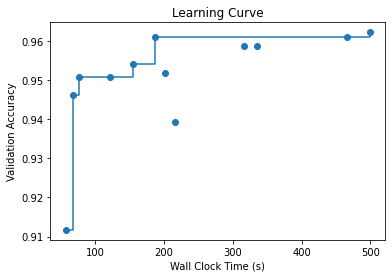

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on FLAML's documentation website https://microsoft.github.io/FLAML/):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below. 
- (abstractive) summarization: generating the textual summarization of an input paragraph. 

For each task, you only have to change the "Load data and preprocess" with the corresponding data loading process. For example, 

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas()
dev_dataset = load_dataset("swag", split="validation").to_pandas()
test_dataset = load_dataset("swag", split="test").to_pandas()

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

No config specified, defaulting to: swag/regular


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.71M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset swag downloaded and prepared to /home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c. Subsequent calls will reuse this data.


No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


In [3]:
train_dataset.head(2)

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0
1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3
